# Requirements

In [65]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import requests
import re
import json
import random
import scipy

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
import proplot as plot


from nltk import ngrams

import seaborn as sns
import geoplot as gplt

import warnings
warnings.filterwarnings('ignore')

import imp

import sddk
import tempun

In [22]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

In [4]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Import the dataset

In [5]:
LIREg = s.read_file("SDAM_data/social_diversity/LIRE_occupsorgs_2021-08-31.geojson", "gdf")
LIREg.head(5)

EDCS-ID                                        publication province  \
0  EDCS-03700724  ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...   Achaia   
1  EDCS-03300852                                     AE 1995, 01409   Achaia   
2  EDCS-28500283  CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...   Achaia   
3  EDCS-09400671  CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...   Achaia   
4  EDCS-24600769                    AE 1995, 01407 = AE 2001, 01812   Achaia   

  province_list                                       place  \
0        Achaia                  Agios Athanasios / Photike   
1        Achaia                                Alea / Tegea   
2        Achaia                                Alea / Tegea   
3        Achaia                                      Andros   
4        Achaia  Archea Olimpia / Archaia Olympia / Olympia   

                                         place_list end_yr_list  \
0                   ['Agios Athanasios', 'Photike']         313   
1                                 ['Alea', 'Tegea']         276   
2                                 ['Alea', 'Tegea']          50   
3                                            Andros         209   
4  ['Archea Olimpia', 'Archaia Olympia', 'Olympia']          96   

                             notes_dating  \
0                                           
1  to 276;   b:  276 to 282         \n\n    
2                                           
3                                           
4                                           

                                         status_list        inscr_type  ...  \
0  ['Augusti/Augustae', 'litterae erasae', 'ordo ...  tituli honorarii  ...   
1           ['Augusti/Augustae', 'miliaria', 'viri']          miliaria  ...   
2              ['Augusti/Augustae', 'leges', 'viri']             leges  ...   
3                ['litterae erasae', 'tituli sacri']      tituli sacri  ...   
4                                                 {}                {}  ...   

  nearest_city_type nearest_city_dist  type_of_inscription_auto  \
0             minor          0.097513     honorific inscription   
1               big          0.004249         mile-/leaguestone   
2               big          0.004249  public legal inscription   
3             minor          0.520308        votive inscription   
4             minor          0.262624  owner/artist inscription   

  type_of_inscription_auto_prob occups occups_N organizations  \
0                           1.0     []        0            []   
1                           1.0     []        0            []   
2                           1.0     []        0            []   
3                           1.0     []        0            []   
4                           1.0     []        0            []   

   organizations_N curator                   geometry  
0                0      []  POINT (20.76680 39.45120)  
1                0      []  POINT (22.41710 37.43190)  
2                0      []  POINT (22.41710 37.43190)  
3                0      []  POINT (24.83230 37.81880)  
4                0      []  POINT (21.62710 37.64790)  

[5 rows x 117 columns]

# Exploring durations

In [6]:
def get_duration(start, stop):
  try:
    duration = abs(int(start) - int(stop)) + 1
    if 0 in range(int(start),  int(stop)):
      duration = duration - 1
  except:
    duration = np.nan
  return duration

LIREg["duration"] = LIREg.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

CPU times: user 156 ms, sys: 11 µs, total: 156 ms
Wall time: 154 ms


(-5.0, 305.0)

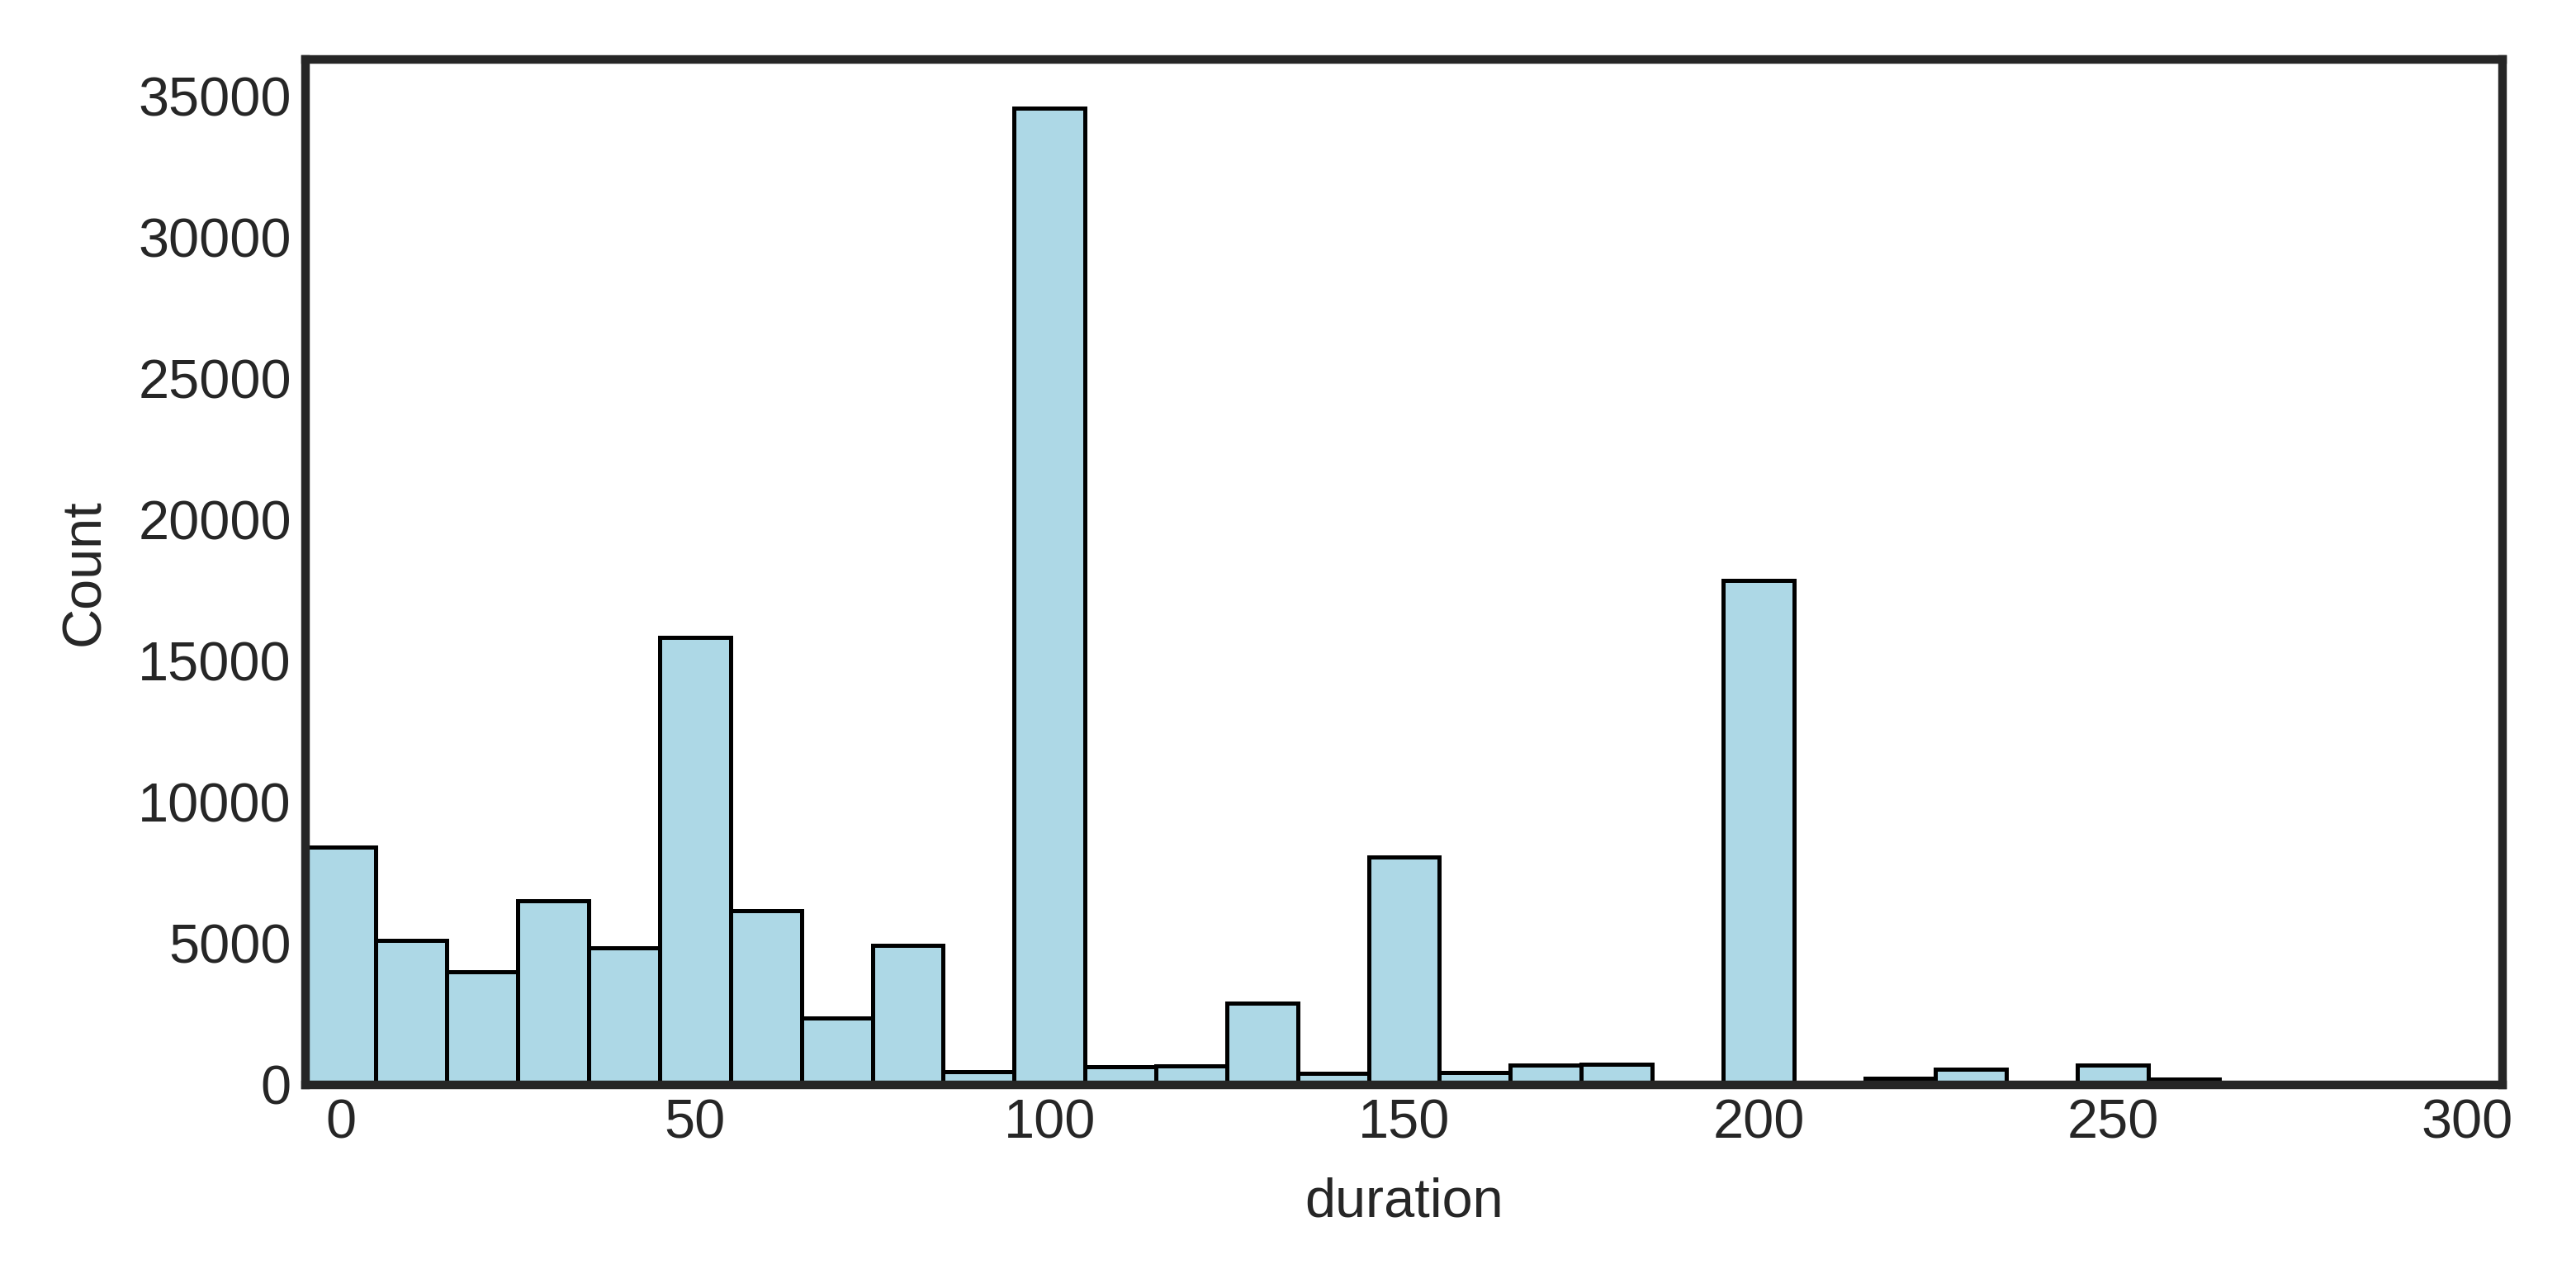

In [7]:
%%time 
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"#"DejaVu Sans"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.2, 2.6), tight_layout=True)
sns.histplot(LIREg["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="lightblue", ax=ax)
ax.set_xlim(-5, 305)

In [14]:
fig.savefig("../figures/durations_histogram.eps", format="eps", dpi=300)

In [17]:
figpath = "SDAM_data/social_diversity/socdiv_figures/"
s.write_file(figpath + "durations_histogram.eps", fig)
s.write_file(figpath + "durations_histogram.png", fig)

A file with the same name ("durations_histogram.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/durations_histogram.eps"
A file with the same name ("durations_histogram.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/durations_histogram.png"


In [18]:
len(LIREg)

137305

In [19]:
durations_df = pd.DataFrame(LIREg.groupby("duration").size().sort_values(ascending=False))
durations_df.reset_index(inplace=True)
durations_df = durations_df.astype(int)
durations_df.columns = ["duration", "count"]
durations_df["pct"] = np.round((durations_df["count"] / len(LIREg)) * 100, 2)
durations_df.head(20)

duration  count    pct
0        100  34127  24.85
1        200  17821  12.98
2         50  15137  11.02
3        150   7621   5.55
4        300   5574   4.06
5         60   5248   3.82
6          1   4332   3.16
7         30   3491   2.54
8        130   2709   1.97
9         40   2689   1.96
10        80   2570   1.87
11         2   2073   1.51
12        70   2045   1.49
13        79   1726   1.26
14        28   1286   0.94
15         3   1157   0.84
16         6   1073   0.78
17        20    947   0.69
18         4    847   0.62
19        41    759   0.55

In [20]:
durations_df.to_csv("../data/durations_table.csv")

# Random dates and overall simulations

In [116]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIREg["random_dates"] = LIREg.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000), axis=1)

CPU times: user 1min 36s, sys: 1.36 s, total: 1min 38s
Wall time: 1min 38s


In [117]:
%%time
LIRE_complete_simulations = tempun.timeblocks_from_randoms(LIREg, "random_dates", [-50, 350, 50])

CPU times: user 7.72 s, sys: 0 ns, total: 7.72 s
Wall time: 7.72 s


In [118]:
LIRE_complete_merged = tempun.simulations_merged(LIRE_complete_simulations)

In [119]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

In [120]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

In [121]:
periods_duration = [abs(tup[1] - tup[0]) for tup in timeblocks_periods]
periods_duration

[95, 27, 95, 42, 48, 52]

In [149]:
%%time
var_data_lire = []
for var_n in range(1000):
    var_data_lire.append([var[var_n] for var in LIREg["random_dates"] if var !=None])

CPU times: user 56.2 s, sys: 56.3 ms, total: 56.3 s
Wall time: 56.3 s


In [150]:
%%time
sim_big = tempun.timeblocks_from_randoms(LIREg[LIREg["urban_context"]=="big"], "random_dates", [-50, 350, 50])
sim_middle = tempun.timeblocks_from_randoms(LIREg[LIREg["urban_context"]=="middle"], "random_dates", [-50, 350, 50])
sim_rest = tempun.timeblocks_from_randoms(LIREg[LIREg["urban_context"]=="rest"], "random_dates", [-50, 350, 50])

CPU times: user 5.52 s, sys: 59.6 ms, total: 5.58 s
Wall time: 5.58 s


In [151]:
LIRE_big = LIREg[LIREg["urban_context"]=="big"]
LIRE_middle = LIREg[LIREg["urban_context"]=="middle"]
LIRE_rest = LIREg[LIREg["urban_context"]=="rest"]

In [152]:
%%time
var_data_big, var_data_middle, var_data_rural = [], [], []
for var_n in range(1000):
    var_data_big.append([var[var_n] for var in LIRE_big["random_dates"] if var !=None])
    var_data_middle.append([var[var_n] for var in LIRE_middle["random_dates"] if var !=None])
    var_data_rural.append([var[var_n] for var in LIRE_rest["random_dates"] if var !=None])

CPU times: user 1min 1s, sys: 311 ms, total: 1min 2s
Wall time: 1min 2s


CPU times: user 56min 43s, sys: 1h 7min 46s, total: 2h 4min 29s
Wall time: 19min 32s


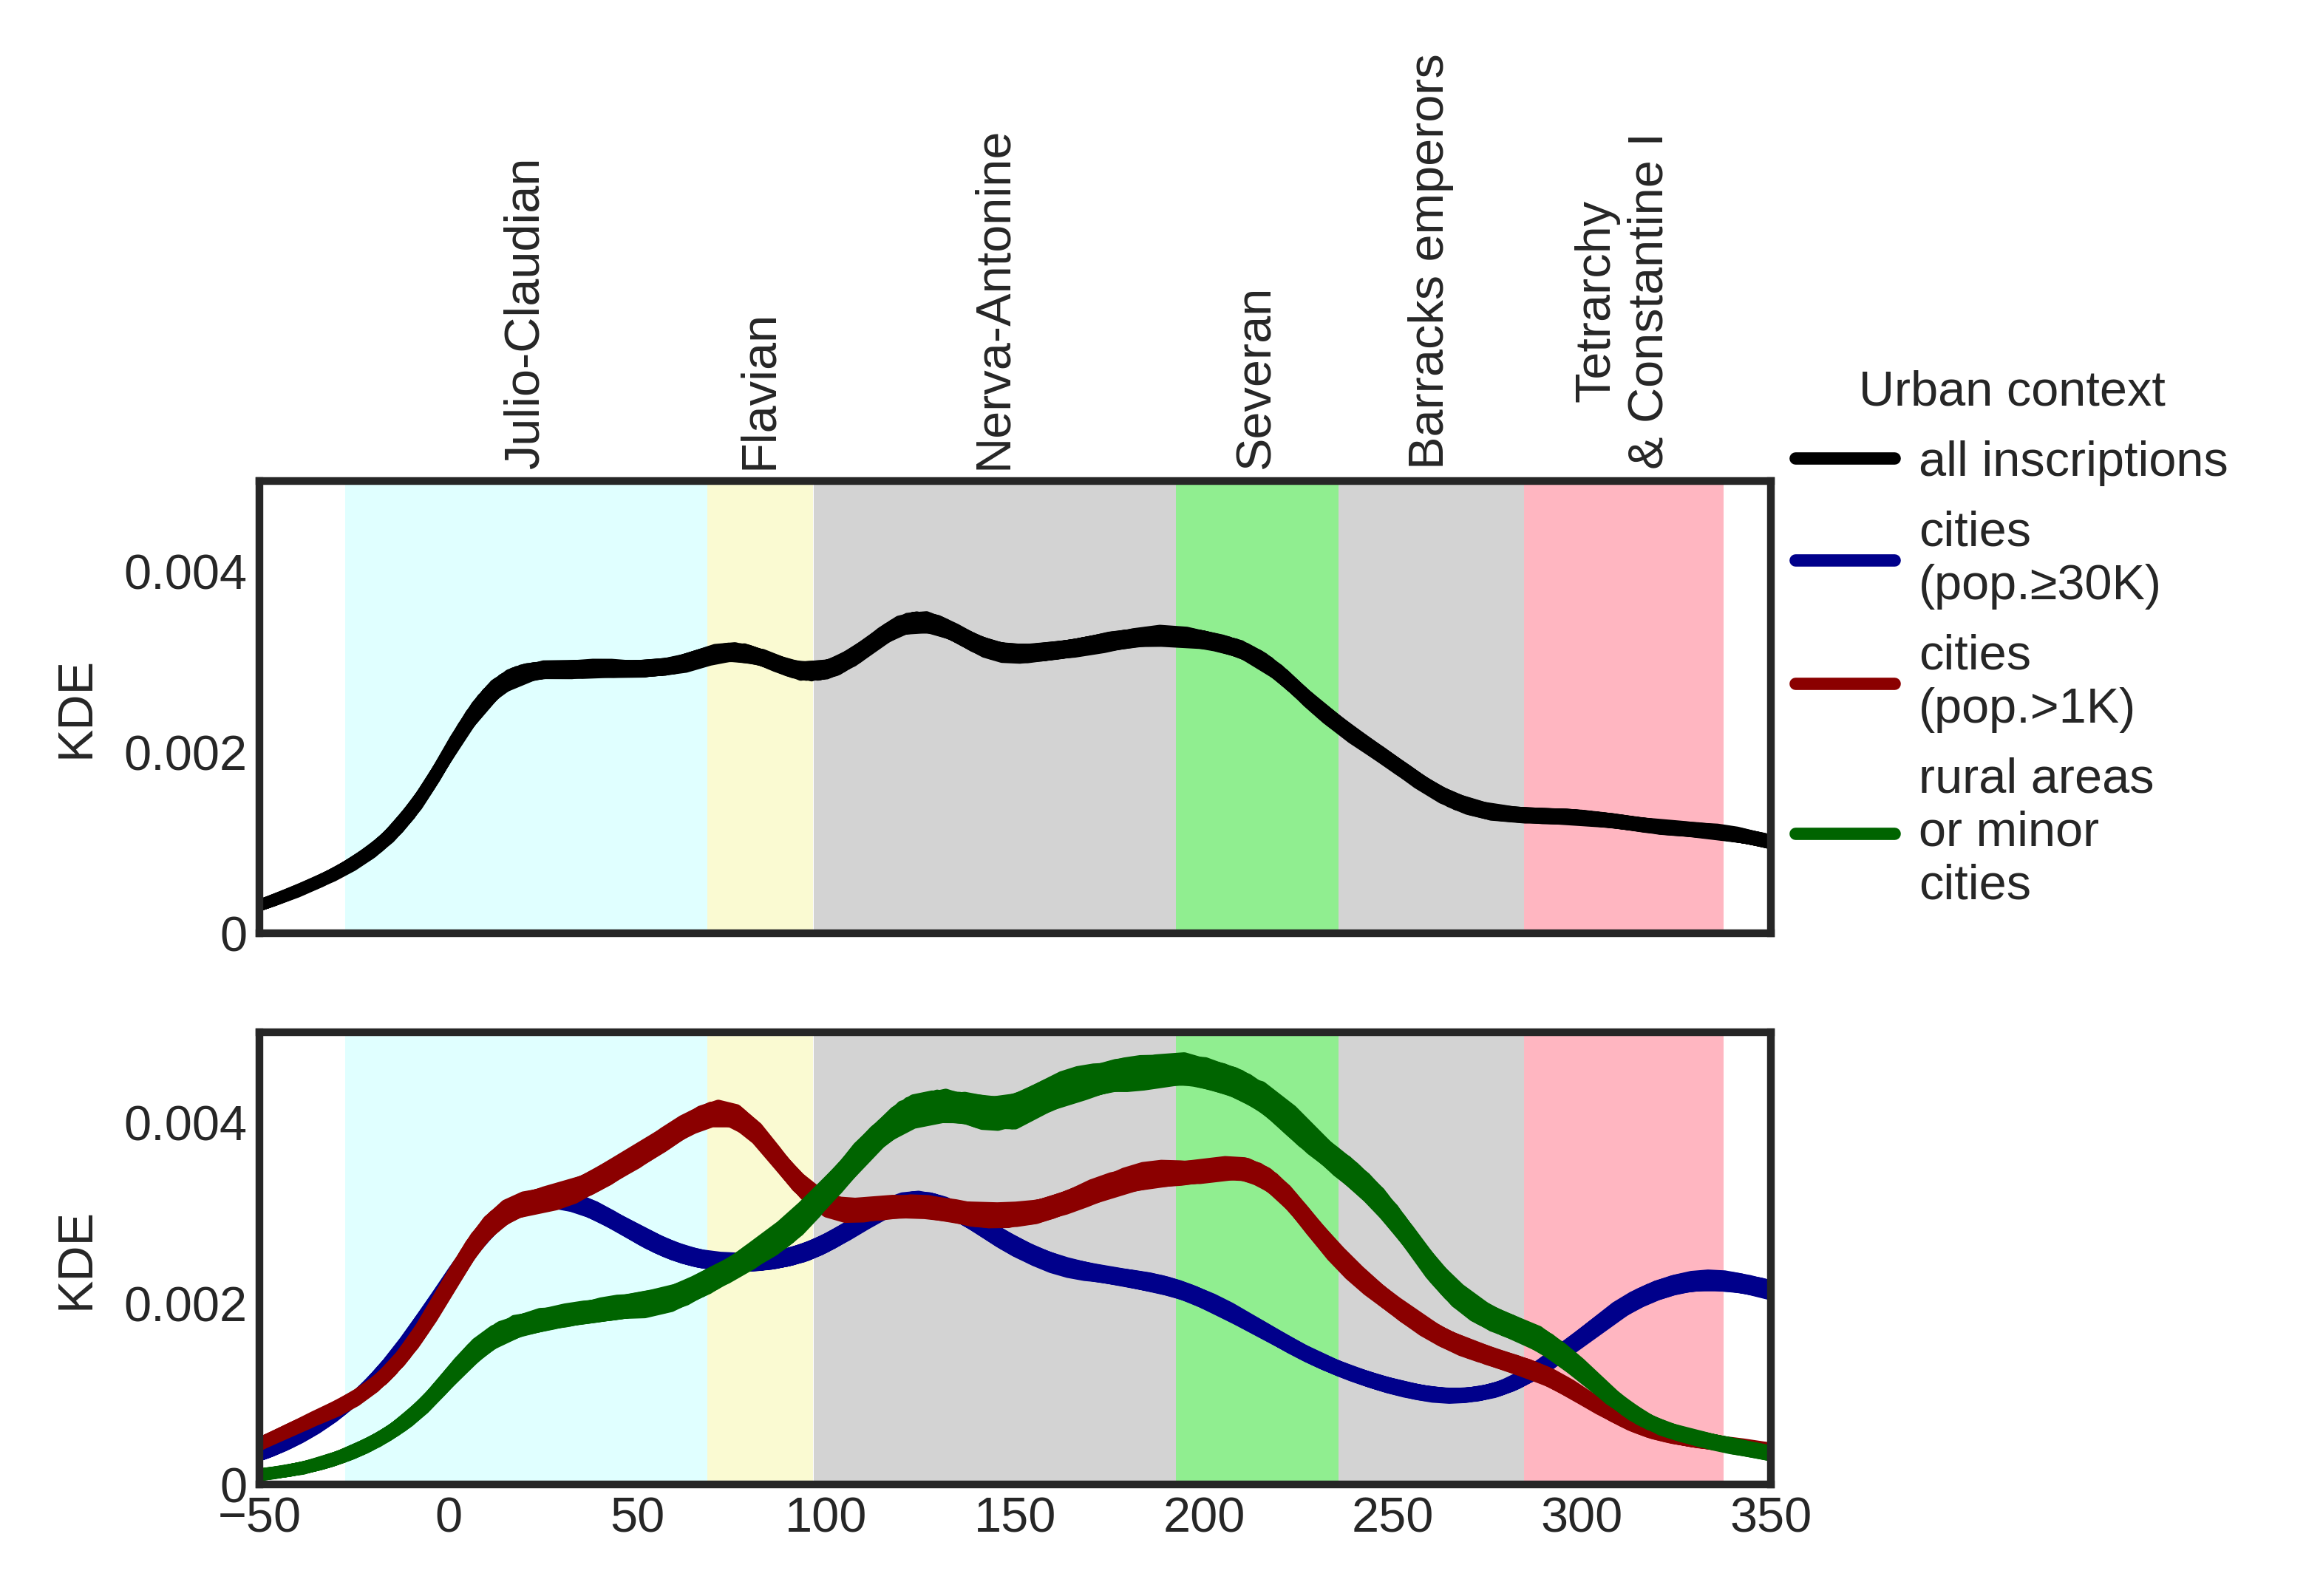

In [158]:
%%time 

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

fig, [ax1, ax3] = plt.subplots(2,1, figsize=[5.2, 3.6], tight_layout=True)


# ax1 - total KDE plot
for data in var_data_lire[:1000]:
    sns.kdeplot(data, ax=ax1, color="black")   

for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
ax1.set_xlim(-50,350)
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.set_ylabel("KDE")
ax1.set_ylim(0,0.005)

# ax3 - KDE plot
for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")

for data in var_data_big[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkblue")
for data in var_data_middle[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkred") 
for data in var_data_rural[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkgreen")     

ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
#ax3.set_xticks([])
ax3.set_ylim(0,0.005)
#ax3.set_title("C", x=0.02, y=0.65)

legend_labels=[
    "all inscriptions",
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural areas\nor minor\ncities"]

colors=["black", "darkblue", "darkred", "darkgreen"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax1.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 0), loc='lower left')

In [159]:
s.write_file(figpath + "temporal_distribution_by_context_kde.png", fig)
s.write_file(figpath + "temporal_distribution_by_context_kde.eps", fig)

A file with the same name ("temporal_distribution_by_context_kde.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context_kde.png"
A file with the same name ("temporal_distribution_by_context_kde.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context_kde.eps"


CPU times: user 44.9 ms, sys: 2.63 ms, total: 47.5 ms
Wall time: 43.4 ms


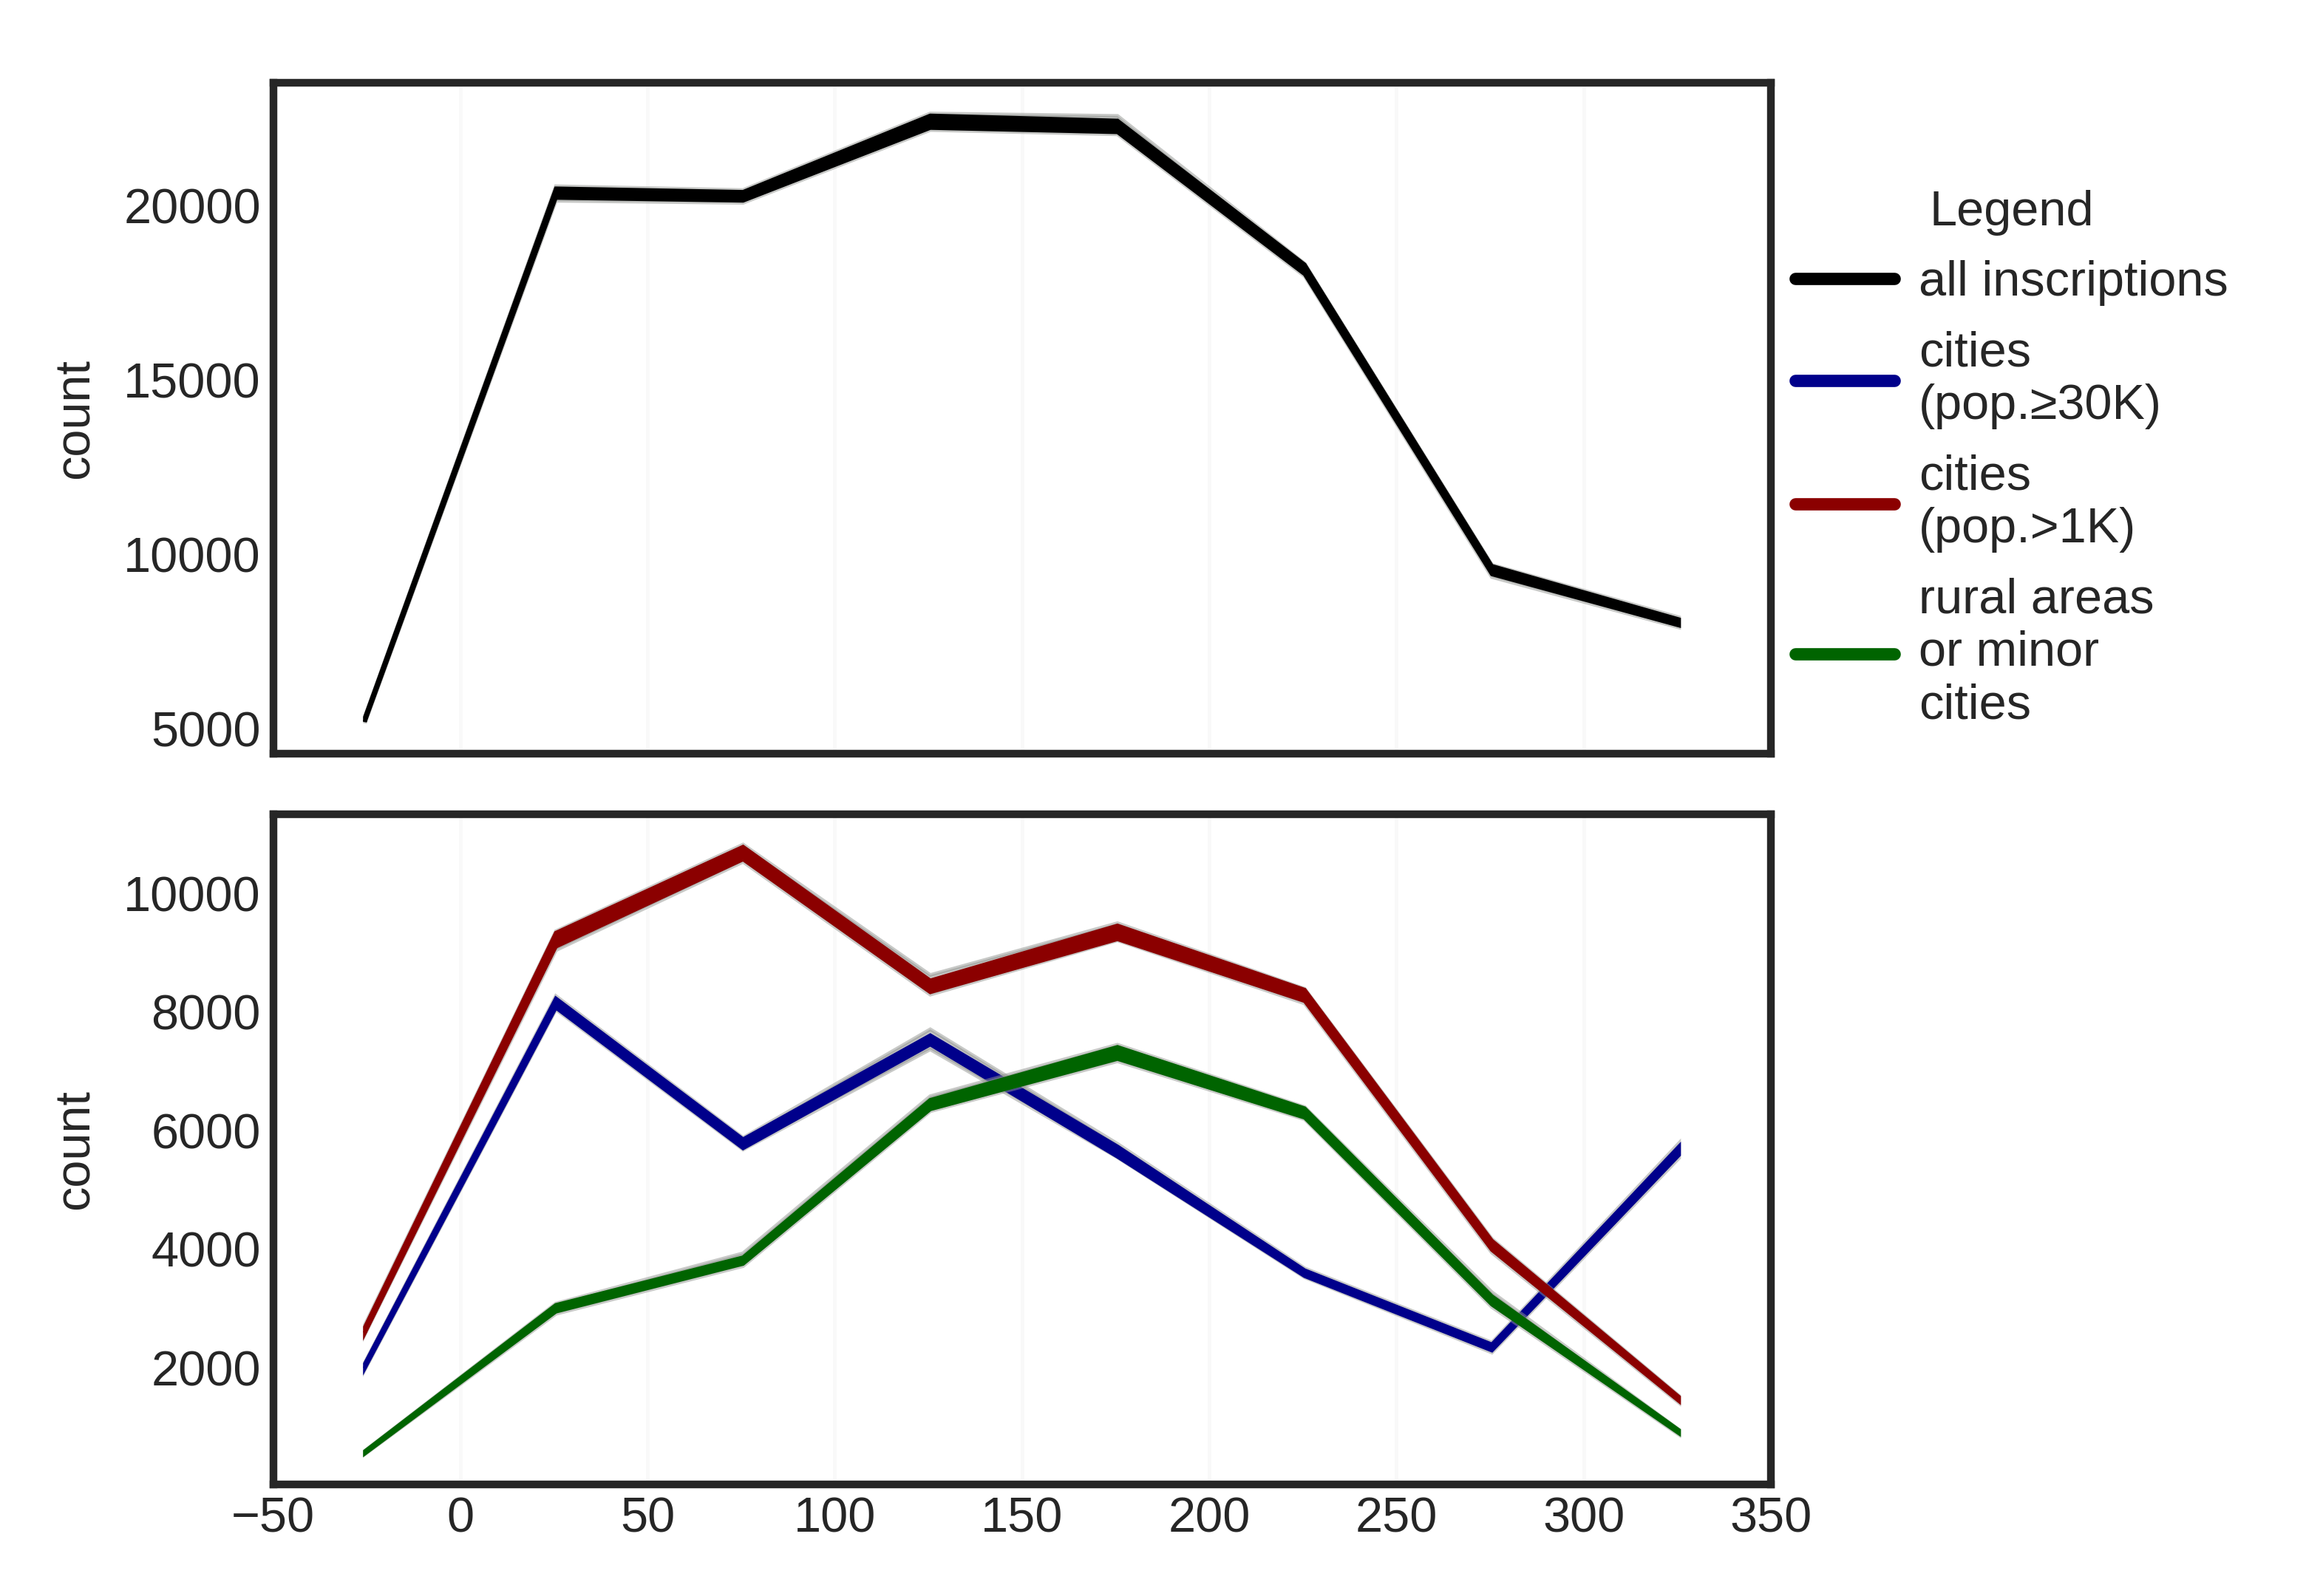

In [160]:
%%time 
labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

fig, [ax2, ax4] = plt.subplots(2,1, figsize=[5.2, 3.6], tight_layout=True)

# ax2 - timeblocks
tempun.plot_timeblocks_data(LIRE_complete_simulations, color="black", ax=ax2)
ax2.set_ylabel("count")
ax2.set_xlim(-50,350)
ax2.xaxis.grid()
ax2.set_xticklabels([])

# ax4 - timeblocks
tempun.plot_timeblocks_data(sim_big, color="darkblue", ax=ax4)
tempun.plot_timeblocks_data(sim_middle, color="darkred", ax=ax4)
tempun.plot_timeblocks_data(sim_rest, color="darkgreen", ax=ax4)
ax4.set_ylabel("count")
ax4.set_xlim(-50,350)
ax4.xaxis.grid()
#ax4.set_title("D", x=0.02, y=0.65)
legend_labels=[
    "all inscriptions",
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural areas\nor minor\ncities"]

colors=["black", "darkblue", "darkred", "darkgreen"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax2.legend(markers, legend_labels, numpoints=1,  title="Legend", bbox_to_anchor=(1, 0), loc='lower left')

In [161]:
s.write_file(figpath + "temporal_distribution_by_context_timeblocks.png", fig)
s.write_file(figpath + "temporal_distribution_by_context_timeblocks.eps", fig)

A file with the same name ("temporal_distribution_by_context_timeblocks.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context_timeblocks.png"
A file with the same name ("temporal_distribution_by_context_timeblocks.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context_timeblocks.eps"


CPU times: user 56min 30s, sys: 1h 7min 42s, total: 2h 4min 13s
Wall time: 19min 21s


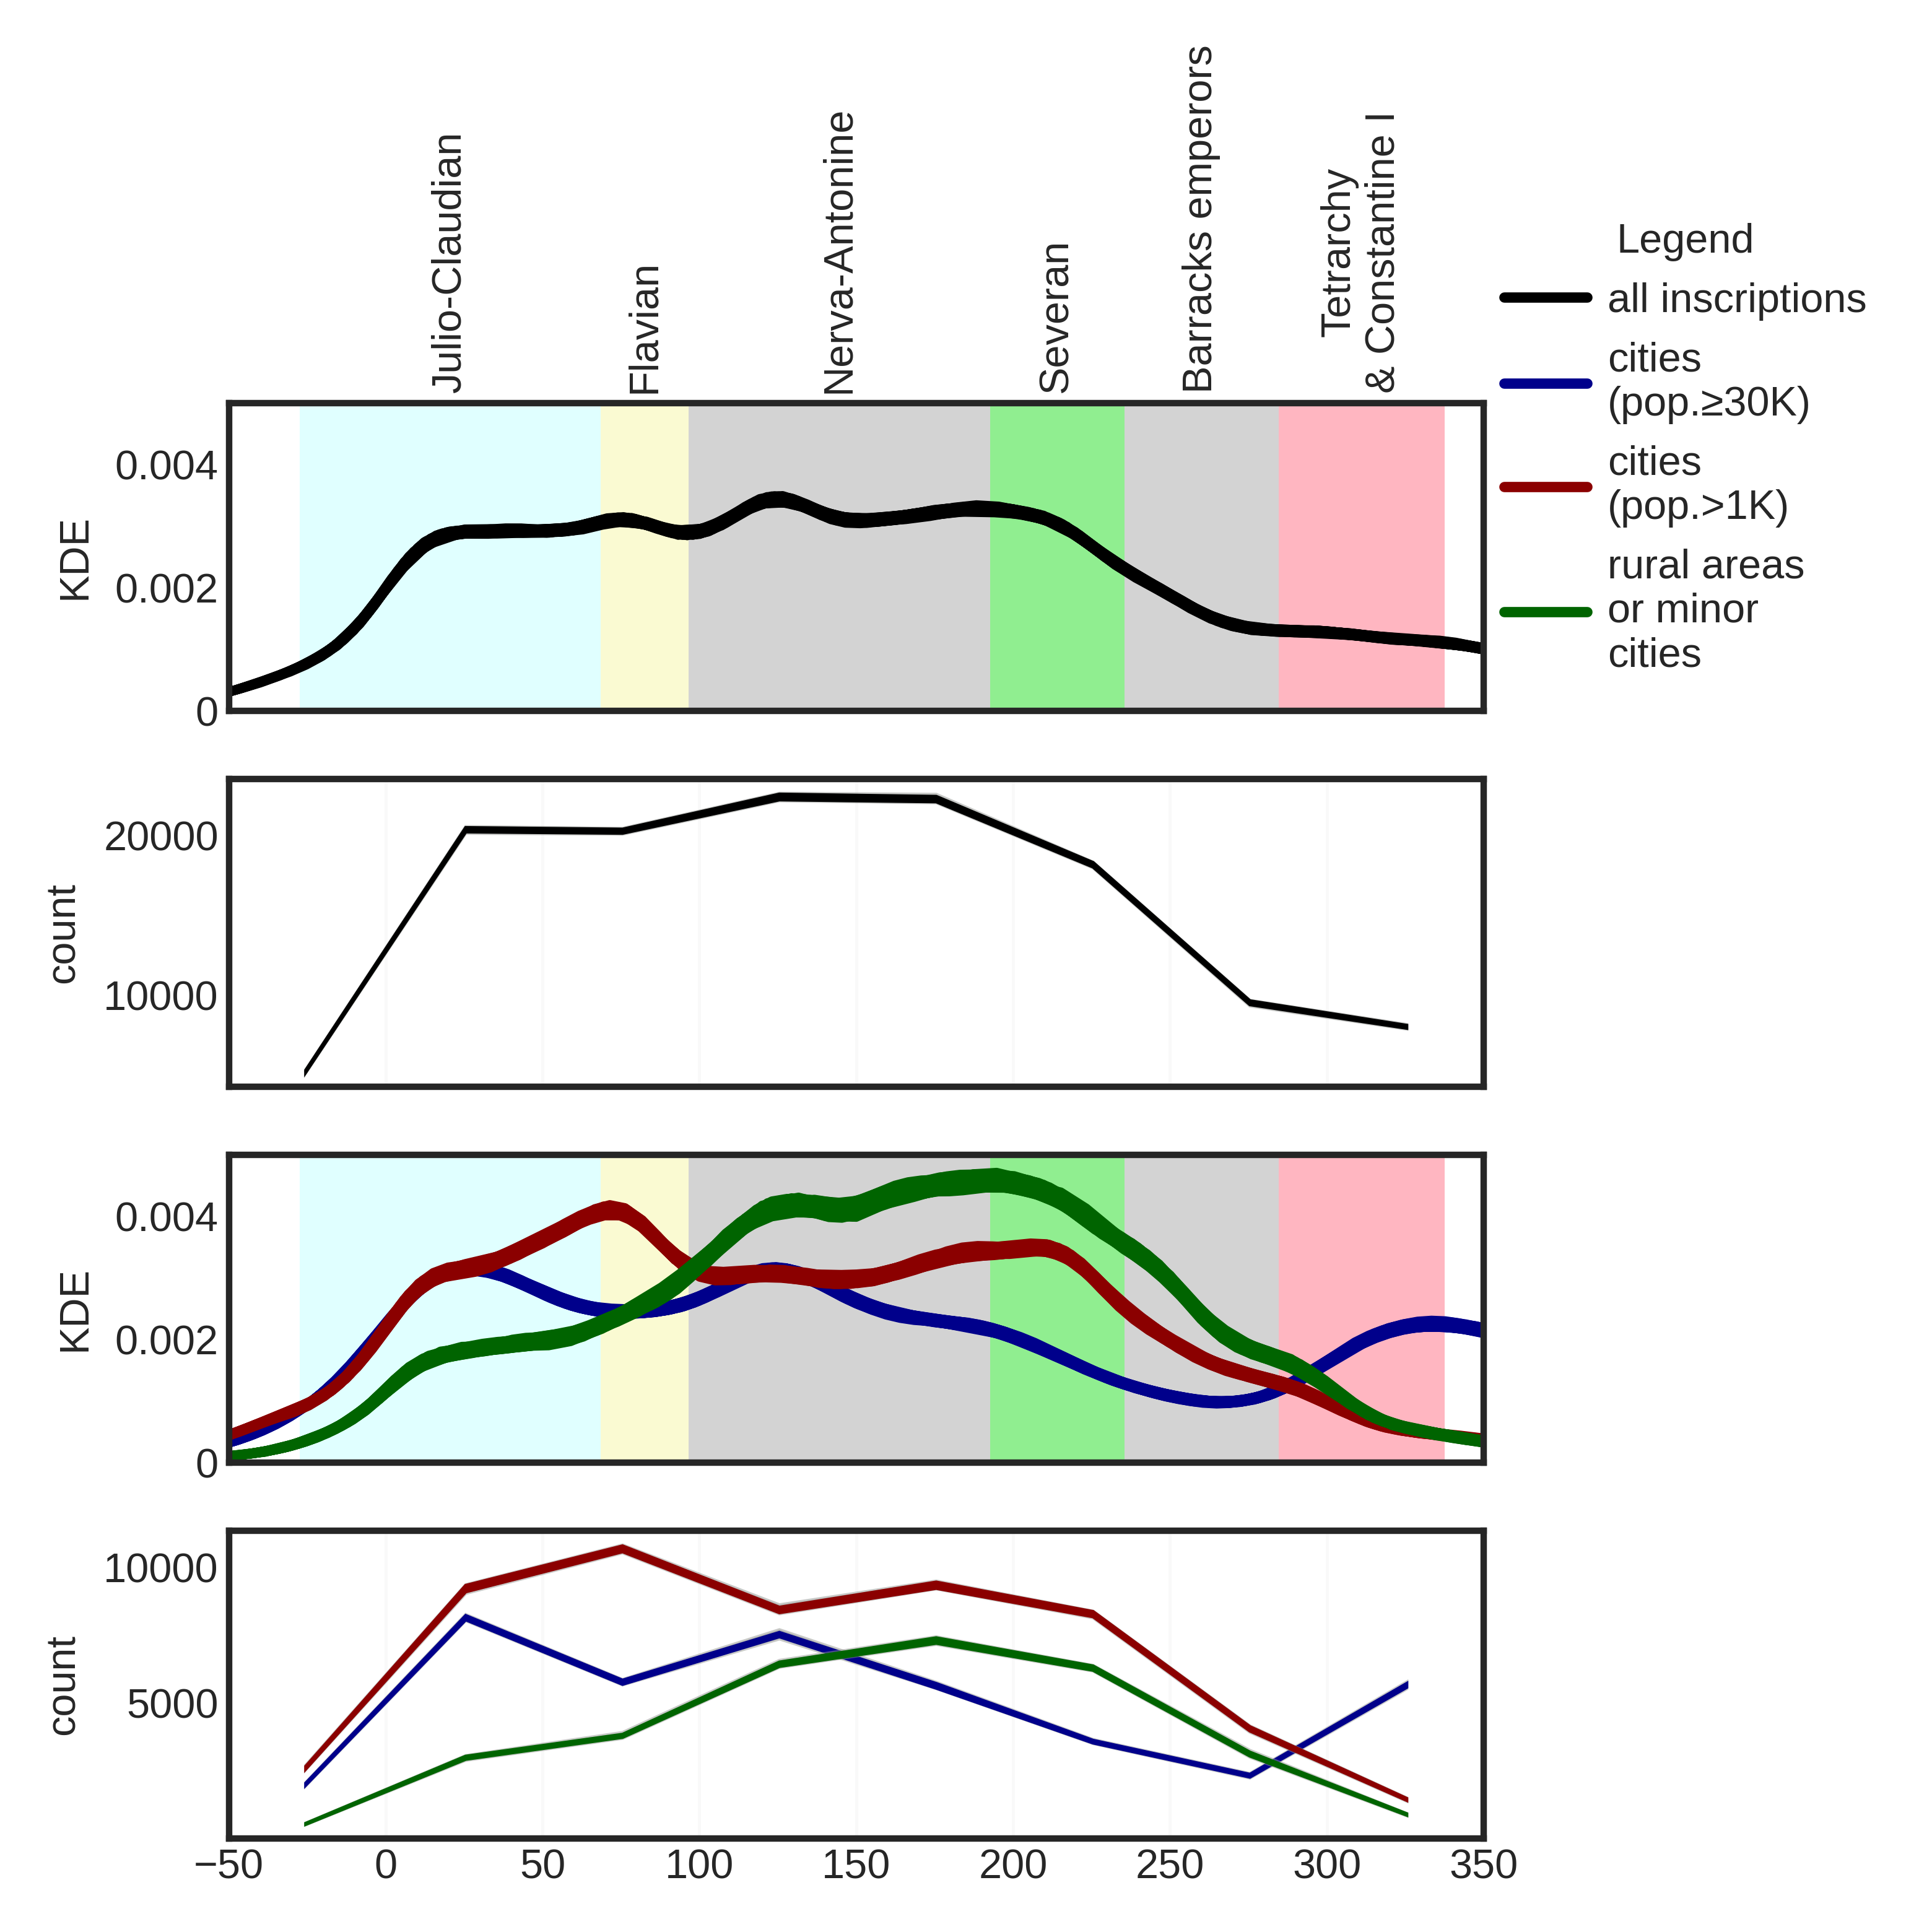

In [162]:
%%time 
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=[5.2, 5.2], tight_layout=True)

# ax1 - total KDE plot
for data in var_data_lire[:1000]:
    sns.kdeplot(data, ax=ax1, color="black")   

for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
ax1.set_xlim(-50,350)
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.set_ylabel("KDE")
ax1.set_ylim(0,0.005)

#ax1.set_title("A", x=0.02, y=0.65) #, loc="left")

# ax2 - timeblocks
tempun.plot_timeblocks_data(LIRE_complete_simulations, color="black", ax=ax2)
ax2.set_ylabel("count")
ax2.set_xlim(-50,350)
ax2.xaxis.grid()
ax2.set_xticklabels([])

# ax3 - KDE plot
for data in var_data_big[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkblue")
for data in var_data_middle[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkred") 
for data in var_data_rural[:1000]:
    sns.kdeplot(data, ax=ax3, color="darkgreen")     

for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
#ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.set_ylim(0,0.005)
#ax3.set_title("C", x=0.02, y=0.65)

# ax4 - timeblocks
tempun.plot_timeblocks_data(sim_big, color="darkblue", ax=ax4)
tempun.plot_timeblocks_data(sim_middle, color="darkred", ax=ax4)
tempun.plot_timeblocks_data(sim_rest, color="darkgreen", ax=ax4)
ax4.set_ylabel("count")
ax4.set_xlim(-50,350)
ax4.xaxis.grid()
#ax4.set_title("D", x=0.02, y=0.65)

legend_labels=[
    "all inscriptions",
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural areas\nor minor\ncities"]

colors=["black", "darkblue", "darkred", "darkgreen"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax1.legend(markers, legend_labels, numpoints=1,  title="Legend", bbox_to_anchor=(1, 0.05), loc='lower left')

In [163]:
s.write_file(figpath + "temporal_distribution_by_context.png", fig)
s.write_file(figpath + "temporal_distribution_by_context.eps", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context.png"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_by_context.eps"


# Christian inscriptions?

In [137]:
def eval_inscr_type(el):
    to_return = []
    if not isinstance(el, float): # i.e. if not nan
        try: el = eval(el)
        except: pass
        if isinstance(el, list):
            return el
        elif isinstance(el, str):
            return [el]
        else:
            return []
    else:
        return []
# test
LIREg["inscr_type"].apply(eval_inscr_type)[82000]

['tituli honorarii']

In [138]:
LIREg["inscr_type_list"] = LIREg["inscr_type"].apply(eval_inscr_type)

In [139]:
inscr_types_flatlist = [
    el for ellist in LIREg["inscr_type_list"].tolist() for el in ellist]

In [140]:
set(inscr_types_flatlist)

{'carmina',
 'defixiones',
 'diplomata militaria',
 'inscriptiones christianae',
 'leges',
 'miliaria',
 'reges',
 'senatus consulta',
 'signacula',
 'termini',
 'tituli fabricationis',
 'tituli honorarii',
 'tituli operum',
 'tituli possessionis',
 'tituli sacri',
 'tituli sepulcrales'}

In [164]:
LIREg["christian"] = LIREg["inscr_type_list"].apply(lambda x: "inscriptiones christianae" in x)

In [165]:
N_christ = len(LIREg[LIREg["christian"]])
N_christ

15742

In [166]:
N_christ_rome = len(LIREg[(LIREg["christian"]) & (LIREg["within_rome"])])
N_christ_rome

13543

In [167]:
# christian inscriptions from rome
(N_christ_rome / N_christ) * 100

86.03099987295134

In [168]:
LIREg_big = LIREg[LIREg["urban_context"]=="big"]

In [169]:
len(LIREg_big[LIREg_big["within_rome"]])

42562

In [170]:
len(LIREg_big[LIREg_big["within_rome"]])

42562

In [171]:
len(LIREg_big[LIREg_big["christian"]]["inscr_type_list"].apply(lambda x: "tituli sepulcrales" in x))

13707

In [172]:
len(LIREg_big[(LIREg_big["christian"]) & (LIREg_big["within_rome"])]["inscr_type_list"].apply(lambda x: "tituli sepulcrales" in x))

13543

In [173]:
sim_big_chr = tempun.timeblocks_from_randoms(LIREg_big[LIREg_big["christian"]==True], "random_dates", [-50, 350, 50])
sim_big_nonchr = tempun.timeblocks_from_randoms(LIREg_big[LIREg_big["christian"]==False], "random_dates", [-50, 350, 50])

In [174]:
%%time
var_data_chr, var_data_nonchr = [], []
for var_n in range(1000):
    var_data_chr.append([var[var_n] for var in LIREg_big[LIREg_big["christian"]==True]["random_dates"] if var !=None])
    var_data_nonchr.append([var[var_n] for var in LIREg_big[LIREg_big["christian"]==False]["random_dates"] if var !=None])

CPU times: user 2min 41s, sys: 388 ms, total: 2min 42s
Wall time: 2min 42s


CPU times: user 2min 15s, sys: 3min 22s, total: 5min 38s
Wall time: 27.3 s


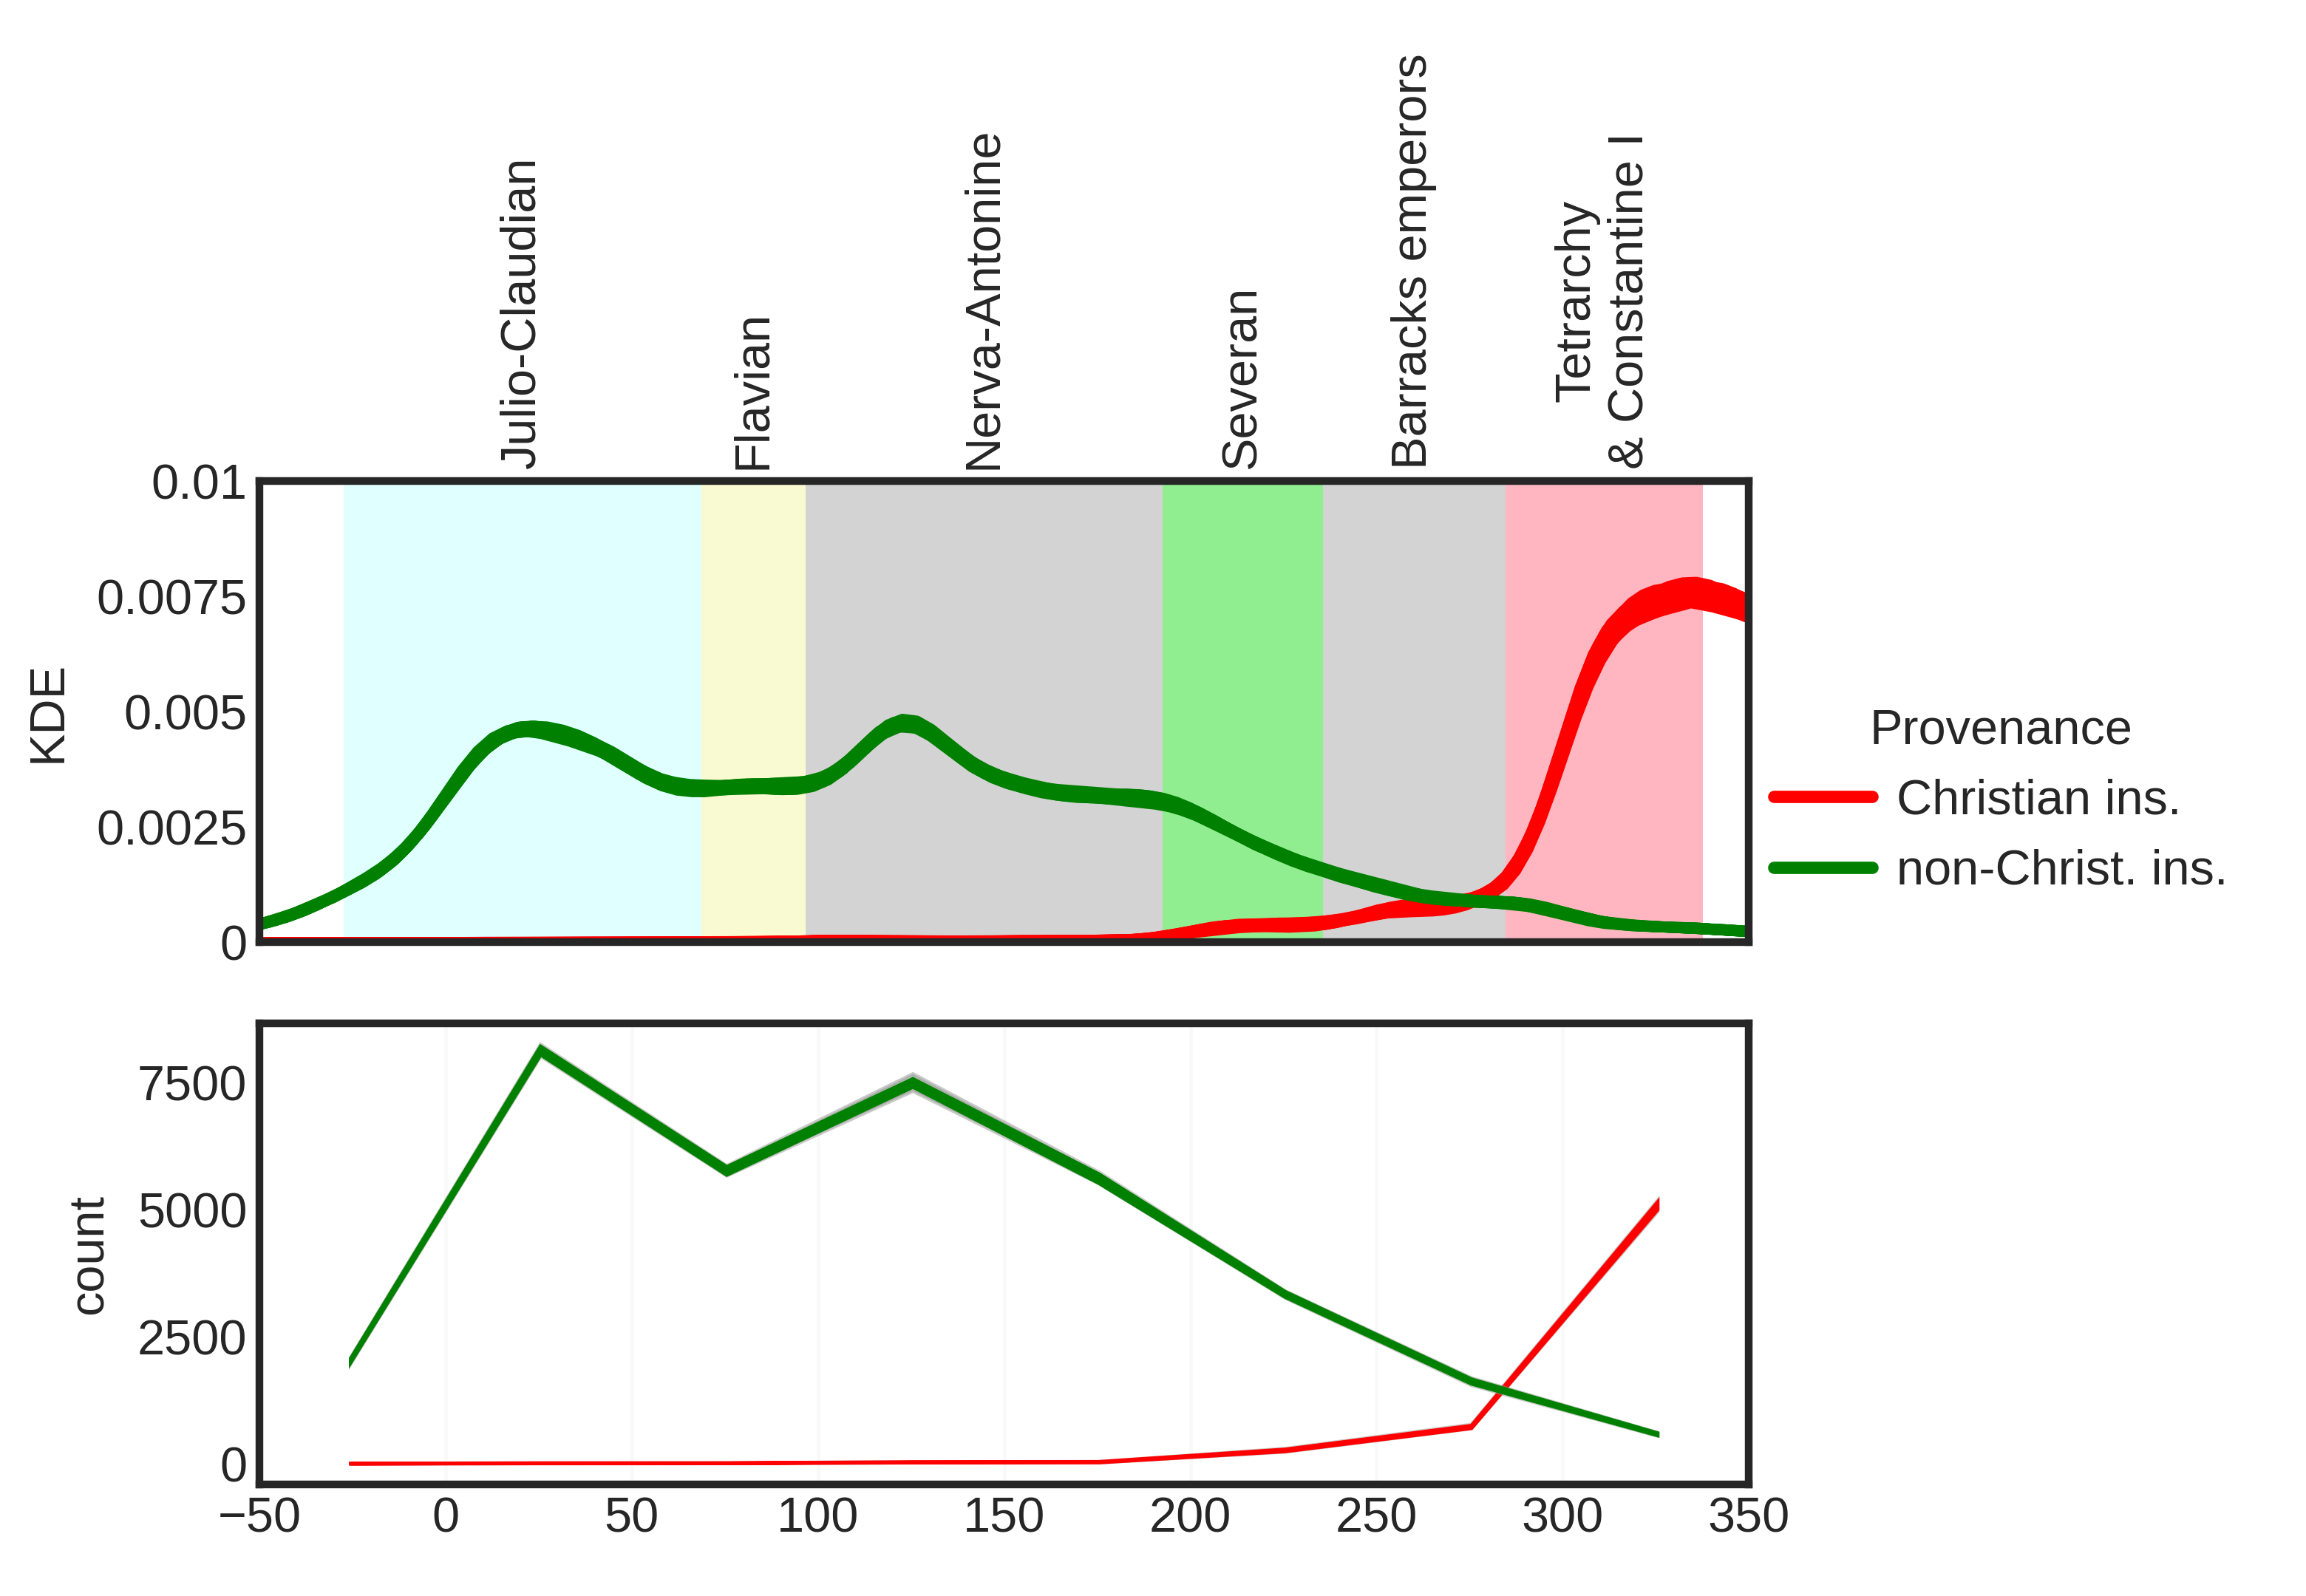

In [176]:
%%time 

sim_N = 100

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5.2, 3.6), tight_layout=True)

for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")

for data in var_data_chr[:sim_N]:
    sns.kdeplot(data, ax=ax1, color="red")
for data in var_data_nonchr[:sim_N]:
    sns.kdeplot(data, ax=ax1, color="green") 
ax1.set_xlim(-50,350)
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.set_ylabel("KDE")
ax1.set_ylim(0,0.01)
    
# ax1
tempun.plot_timeblocks_data(sim_big_chr, color="red", ax=ax2)
tempun.plot_timeblocks_data(sim_big_nonchr, color="green", ax=ax2)

ax2.set_ylabel("count")
ax2.set_xlim(-50,350)
ax2.xaxis.grid()
#ax4.set_title("D", x=0.02, y=0.65)

legend_labels=[
    "Christian ins.",
    "non-Christ. ins."]

colors=["red", "green"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax1.legend(markers, legend_labels, numpoints=1,  title="Provenance", bbox_to_anchor=(1, 0.05), loc='lower left')

In [178]:
s.write_file(figpath + "temporal_distribution_christ.png", fig)
s.write_file(figpath + "temporal_distribution_christ.eps", fig)

A file with the same name ("temporal_distribution_christ.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_christ.png"
A file with the same name ("temporal_distribution_christ.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/temporal_distribution_christ.eps"


# Spatial dissemination of inscriptions

In [179]:
def get_date_var(randoms):
    try: return randoms[0]
    except: return None
LIREg["date_var_1"] = LIREg["random_dates"].apply(get_date_var)

In [180]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + "BC"
    else: 
        date = str(date) + "AD"
    return date

periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + " ({0}-{1})".format(start, end))
periods_labels

['Julio-Claudian (27BC-68AD)',
 'Flavian (69AD-96AD)',
 'Nerva-Antonine (97AD-192AD)',
 'Severan (193AD-235AD)',
 'Barracks emperors (236AD-284AD)',
 'Tetrarchy\n& Constantine I (285AD-337AD)']

In [181]:
### # pelagios provinces - only for plotting purposes
pleiades_regions = gpd.read_file('../data/pleiades_regions.geojson', driver='GeoJSON')

In [182]:
lire_df_by_periods = []

for period in timeblocks_periods:
    lire_sample = LIREg[LIREg["date_var_1"].between(period[0], period[1])]
    lire_df_by_periods.append(lire_sample)

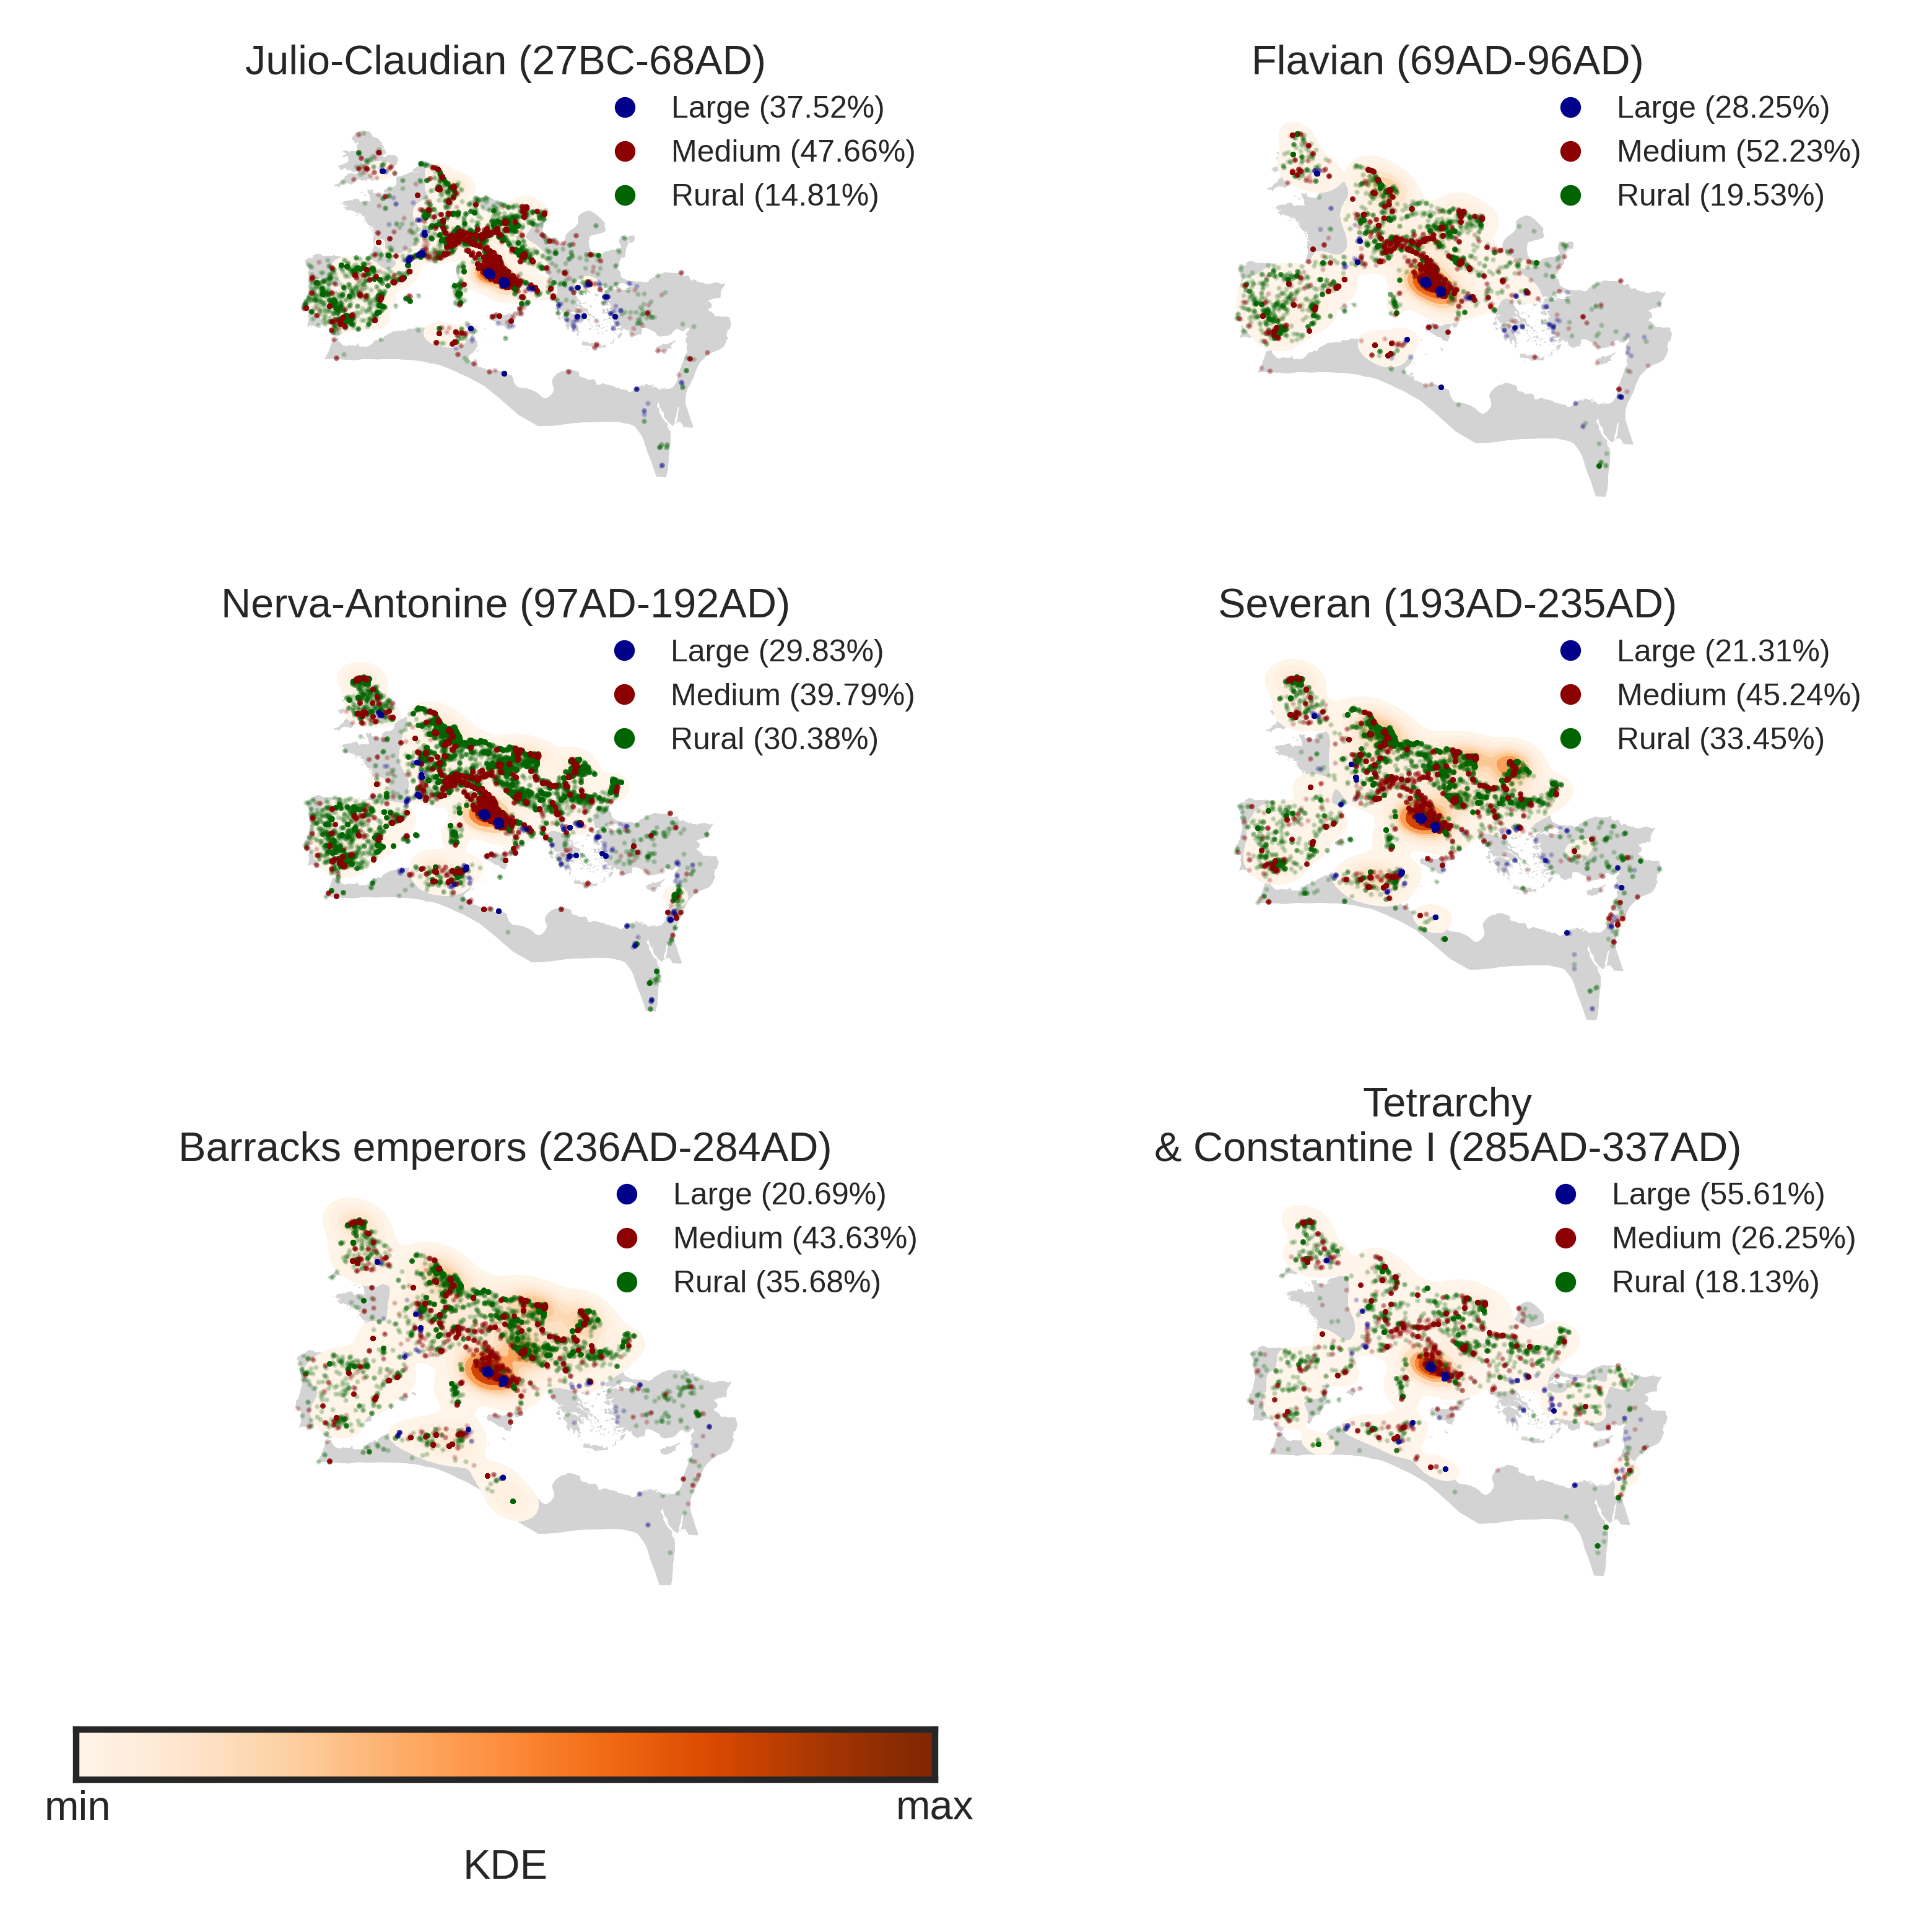

In [183]:
fig, axs  = plt.subplots(4, 2, figsize=(5.2, 5.2), tight_layout=True, gridspec_kw={
                           'width_ratios': [1, 1],
                           'height_ratios': [8, 8, 8, 1]})

contexts_pct = {}

for df, ax, period in zip(lire_df_by_periods, axs.ravel(), periods_labels):
    pleiades_regions.plot(ax=ax, color="lightgray", zorder=2)
    gplt.kdeplot(df, cmap='oranges', ax=ax, shade=True, zorder=2)
    for context, color in [("rest", "darkgreen"), ("middle", "darkred"), ("big", "darkblue")]:
        df_context = df[df["urban_context"]==context]
        contexts_pct[context] = str(np.round(((len(df_context) / len(df)) * 100), 2)) + "%"
        df_context.plot(markersize=0.2, alpha=0.2, color=color, ax=ax, zorder=3)
    ax.set_title(period, fontsize=8)
    ax.set_axis_off()
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkblue", "darkred", "darkgreen"]]
    
    legend_labels = ["Large ({0})".format(contexts_pct["big"]), "Medium ({0})".format(contexts_pct["middle"]), "Rural ({0})".format(contexts_pct["rest"])]
    ax.legend(markers, legend_labels, numpoints=1, bbox_to_anchor=(0.65, 1.05), loc='upper left', fontsize=6)
    ax.set_rasterization_zorder(3)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))    
axs[3,0].imshow(gradient, aspect='auto', cmap=plt.get_cmap("oranges"))
axs[3,0].set_yticklabels([])
axs[3,0].set_xticks([0, 256])
axs[3,0].set_xticklabels(["min", "max"])
axs[3,0].set_xlabel("KDE")

axs[3,1].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)

In [113]:
sddk.write_file(figpath + "spatial_distribution_tempo.eps", fig, conf)
sddk.write_file(figpath + "spatial_distribution_tempo.png", fig, conf)

A file with the same name ("spatial_distribution_tempo.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/spatial_distribution_tempo.eps"
A file with the same name ("spatial_distribution_tempo.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/spatial_distribution_tempo.png"


# Inscriptions over time: Word counts & character counts

In [184]:
# functions to be used to extract interesting information from timeblocks simulation data

def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()

def charcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock"""
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words

def unique_words_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock
    in proportion to total number of words"""
    wordcount = timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount

def extract_ngrams(text, width=4):
    """extracts character ngrams from a string of given width
    returns: list of ngrams"""
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(text), width))]
    return char_ngrams

def unique_ngrams(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique)

def unique_ngrams_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock
    in proportion to total number of characters"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount

In [ ]:
%%time
wordcounts_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], wordcount) 
wordcounts_avg_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], wordcount_avg) 
charcounts_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], charcount) 
charcounts_avg_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], charcount_avg) 
unique_words_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], unique_words)
unique_ngrams_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], unique_ngrams)

In [ ]:
sim_data_list = [
    (LIRE_complete_simulations, "(A) inscription counts", "count"),
    (wordcounts_data, "(B) word counts", "count"),
    (charcounts_data,  "(C) character counts", "character count"),
    (unique_words_data, "(D) unique words", "count"),
    (unique_ngrams_data, "(E) unique character four-grams", "count"),
    (charcounts_avg_data, "(F) avg. char. counts per ins.", "avr. char. count")]

In [ ]:
mpl.rcParams["axes.formatter.limits"] = [-5, 10]

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 5.2), tight_layout=True)

for sim_data, ax, color in zip(sim_data_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    tempun.plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        #ax.set_yticklabels(ticks_K)
# to hide an axis:
#axs[3,1].set_axis_off()       

In [116]:
s.write_file(figpath + "various_ins_counts_temporal.png", fig)
s.write_file(figpath + "various_ins_counts_temporal.eps", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/various_ins_counts_temporal.png"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/various_ins_counts_temporal.eps"


# Inscriptions over time: Types of inscriptions

In [ ]:
simulations_by_type_len = []

for ins_type in LIREg["type_of_inscription_auto"].unique():
    if ins_type != "NULL":
        subset_df = LIREg[LIREg["type_of_inscription_auto"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

In [37]:
simulations_by_type[4][1]

3307

In [456]:
simulations_by_type = []

for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    simulations = timeblocks_from_randoms(subset_df, "random_dates", [-200, 600, 100])
    ins_type_N =len(subset_df)
    simulations_by_type.append([ins_type_tup[0],ins_type_N, simulations]) 
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [451]:
date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    date_vars = []
    for n in range(100):
        date_vars.append([date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 2min 22s, sys: 3min 18s, total: 5min 41s
Wall time: 33.5 s


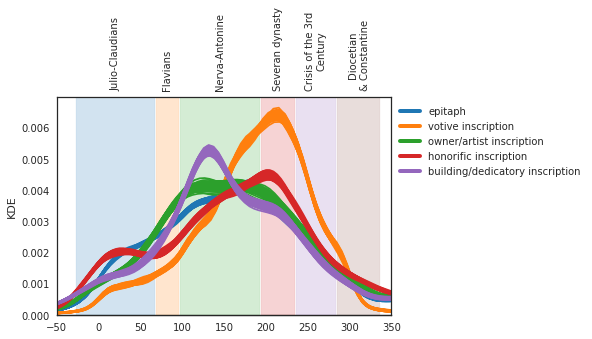

In [457]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

labels_ins = [tup[0] for tup in simulations_by_type_len]

for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.2)#, linestyles="dashed", color="red")

for instype_data, color in zip(date_vars_by_instypes[:5], tab_colors_list[:5]):
    for sim_var in instype_data:
        sns.kdeplot(sim_var, ax=ax, color=color)
        

ax.set_xlim(-50,350)
ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, labels_ins[:5], bbox_to_anchor=(1, 1), loc='upper left')


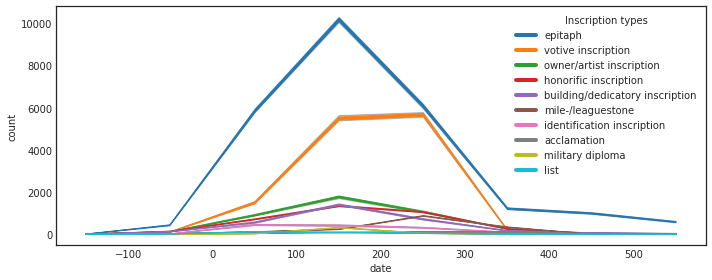

In [40]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax  = plt.subplots(figsize=(10, 4), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type, tab_colors_list[:len(simulations_by_type)]):
    plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)
    
ax.set_xlabel("date")
ax.set_ylabel("count")
#ax.set_title("EDH - 10 most common inscription types over time")
 
markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type], numpoints=1,  title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [220]:
sddk.write_file("SDAM_data/social_diversity/EDH_inscription_types_temporal.png", fig, conf)

A file with the same name ("EDH_inscription_types_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_inscription_types_temporal.png"
